# Rankine-Hugoniot solver

流体の保存の式は
$$
\frac{\partial F}{\partial t}+\frac{\partial G}{\partial x}=0
$$
で表されるが、定常性の仮定の下で不連続面の存在を考慮したとき

$$
[G]^2_1 = G_2 - G_1 = 0\quad\rightarrow\quad G_2=G_1
$$

が成り立つ（但し添字の1, 2は不連続面の上流・下流側の量を示す）。ここで$G$は

* mass flux
* momentum flux
* energy flux

であり、これらが不連続面の両側で保存されることを意味している。電磁流体（MHD）において、これは

$$
[\rho u]^2_1=0
$$

$$
[\rho {u_x}^2 + P+\frac{1}{2\mu_0}B^2]^2_1=0
$$

$$
[\rho u_x u_t-\frac{1}{\mu_0}B_x B_t]^2_1 = 0
$$

$$
[\frac{1}{2}u^2+\frac{\gamma}{\gamma-1}\frac{P}{\rho}]^2_1=0
$$

但しここで座標系はde Hoffmann-Teller frame（流体速度$\parallel$磁場）を仮定することから、電場はゼロとなることでenergy fluxの保存式におけるPoynting flux項は考慮していない。

また誘導方程式と磁力線凍結（$\vec{E}+\vec{u}\times\vec{B}=0$）より

$$
[u_x B_t - u_t B_x]^2_1 = 0
$$

も成り立つ（ここで$x,\ t$成分は不連続面の法線方向、接線方向を示すとする）。

以上の関係式を用いると、衝撃波の上下流（$n=1, 2$）の流体速度の法線成分をnormal Alfven velocityで規格化した

$$
A_{xn} = \frac{u_{xn}}{\frac{B_x}{\sqrt{\mu_0 \rho_n}}}, 
$$

は以下の関係式を満たす（Hau and Sonnerup, JGR 1989より）。

$$
\begin{equation}
{A_{x1}}^2=\left[{A_{x2}}^2\left( \frac{\gamma-1}{\gamma}\left( \frac{\gamma+1}{\gamma-1}-\tan^2\theta\right)\left({A_{x2}}^2-1\right)^2 + \tan^2\theta\left(\frac{\gamma-1}{\gamma}{A_{x2}}^2-1\right)\left({A_{x2}}^2-2\right) \right)-\frac{\beta}{\cos^2\theta}\left({A_{x2}}^2-1\right)^2\right]/\left[\frac{\gamma-1}{\gamma}\frac{{({A_{x2}}^2-1)}^2}{\cos^2\theta}-{A_{x2}}^2\tan^2\theta\left(\frac{\gamma-1}{\gamma}{A_{x2}}^2-1\right)\right]
\tag{1}
\end{equation}
$$

$A_{xn}$の値を用いることで、プラズマ密度や磁場、圧力の上下流の関係は以下のように求まる。
$$
\frac{\rho_2}{\rho_1}=\frac{{A_{x1}}^2}{{A_{x2}}^2}
\tag{2}
$$

$$
\frac{B_{t2}}{B_{t1}}=\frac{\tan\theta_2}{\tan\theta}=\frac{{A_{x1}}^2-1}{{A_{x2}}^2-1}
\tag{3}
$$

$$
{A_{x2}}^2+\frac{\beta_2 + 1}{2\cos^2\theta_2}={A_{x1}}^2+\frac{\beta + 1}{2\cos^2\theta}
\tag{4}
$$

このように、衝撃波上下流の物理量の関係は上流のプラズマβと衝撃波角$\theta$（磁場と衝撃波法線方向の成す角度）をパラメータとして求めることができる。以下のプログラム（RHbase.py）では、MHD_RHクラスにおいて$(\beta, \theta)$を入力データとして作成したインスタンスから、MHDの各モード（fast, slow, intermediate）の位相速度や衝撃波圧縮率などを求めることができる。

In [18]:
# RHbase.py
import sys
import numpy as np

class MHD_RH:
    def __init__(self, beta, theta, xacc=1.e-6):
        # beta and theta : upstream quantities
        # squared mf: fast MS, ms: slow MS, mi: another branch of Alfven mode
        # normalized by the normal Alfven velocity 
        self.beta = beta
        self.theta = theta
        self.mf = self.rhsol(1.0+xacc, 1.e+10)
        self.ms = self.rhsol(0.0, 1.0-xacc)
        self.mi = self.rhsol(0.0, 1.0, alf_mode=True)
        self.mcd, self.mcu = self.critical_Alfven()

    def ax1(self, ax2, gamma=5./3.):
        # determine the square of the upstream Alfven Mach number from that in the downstream
        beta = self.beta
        theta = self.theta
        deg2rad = np.pi/180.
        tanth2 = np.tan(theta*deg2rad)**2
        costh2 = np.cos(theta*deg2rad)**2

        x1 = ax2*( (gamma-1.)/gamma * ( (gamma+1.)/(gamma-1.) - tanth2 ) * \
                       (ax2-1.)**2 + tanth2*( (gamma-1.)/gamma*ax2 - 1. ) * \
                       ( ax2-2.) ) - beta/costh2*(ax2-1.)**2
        x2 = (gamma-1.)/gamma * (ax2-1.)**2/costh2 - ax2*tanth2*( (gamma-1.)/gamma*ax2 - 1. )

        return x1/x2

    def rhsol(self, x1, x2, alf_mode=False, xacc=1.e-6, iteration=1000):
        beta = self.beta
        theta = self.theta
        for j in range(iteration):
            if(alf_mode):
                x1ref = x2ref = 1.0
            else:
                x1ref = x1
                x2ref = x2
            f2 = self.ax1(x2) - x2ref
            f1 = self.ax1(x1) - x1ref
            if f1*f2 > 0:
                print('root must be bracketed in bisection')
                break
            xmid = 0.5 * (x2 + x1)
            if(alf_mode):
                xref = 1.0
            else:
                xref = xmid
            fmid = self.ax1(xmid) - xref
            if f1*fmid > 0.0:
                x1 = xmid
            else:
                x2 = xmid
            if np.absolute(fmid) < xacc:
                return np.sqrt(xmid)
        print('lack of iteration')

    def critical_Alfven(self, step = 1.e-5):
        # determine the critical Alfven Mach number
        # Ma_down > xmax: weak intermediate shock
        # Ma_down < xmax: strong intermediate shock
        # ymax: critical Alfven Mach number of upstream flow
        ymax = -1.e+10
        x = (self.ms)**2
        while x < 1.0:
            y = self.ax1(x)
            if y > ymax:
                xmax = x
                ymax = y
            x = x + step
        return np.sqrt(xmax), np.sqrt(ymax)

    def solsearch(self, xdown, mode):
        # mode 1: fast shock 2: slow shock 3: IS
        ax2 = xdown**2
        deg2rad = np.pi/180.
        while(True):
            if mode == 1:
                if ax2 > self.mf:
                    break
            elif mode == 2:
                if self.ms < ax2 < self.mi:
                    break
            else:
                if self.mi < ax2 < 1.0:
                    break
            print('value is not suitable for RH')
            sys.exit()

        ax1 = self.ax1(ax2)
        self.ratio = ax1/ax2
        self.thetad = np.rad2deg( np.arctan( (ax1-1.)/(ax2-1.)*np.tan(self.theta*deg2rad) ) )
        self.bd = np.cos(self.theta*deg2rad)/np.cos(self.thetad*deg2rad)
        self.bt = self.bd * np.sin(self.thetad*deg2rad)
        self.uin = (1.-1./self.ratio)*np.sqrt(ax1)*np.cos(self.theta*deg2rad)
        self.vshock = np.sqrt(ax2/self.ratio)*np.cos(self.theta*deg2rad)

python起動後に

`from RHbase import *`

としてから*obj* = MHD_RH(*beta*, *theta*)とインスタンスを作成する。以下の例では$\beta=0.1,\ \theta=60^\circ$の場合について計算する。

In [11]:
from RHbase import *
va = MHD_RH(0.1, 60.)

$A_{x1}=A_{x2}$となる解がMHDにおける位相速度（fast/slow）に該当し、それぞれ`va.mf, va.ms`で参照できる。ここで表示される値はnormal Alfven velocityで規格化されたものなので、実際のAlfven Mach numberはこれに$\cos\theta$を乗じれば求められる。なおAlfven modeにおいては$A_{x1}=A_{x2}=1$である。

In [12]:
print(va.mf, va.ms)

2.0627636659400523 0.27989194054422983


次に$({A_{x1}}^2, {A_{x2}}^2)$の関係をグラフに表してみる。

Text(0,0.5,'${A_{x1}}^2$')

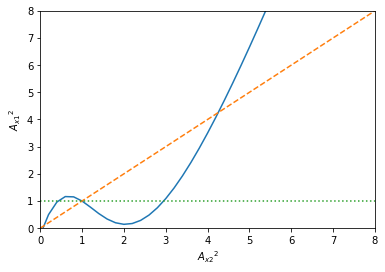

In [13]:
ax2 = np.arange(100)*0.2
ax1 = va.ax1(ax2)
%matplotlib inline

plt.plot(ax2, ax1)
plt.plot(ax2, ax2, linestyle='dashed')
plt.plot([0,8],[1,1],linestyle='dotted')
plt.xlim(0,8)
plt.ylim(0,8)
plt.xlabel('${A_{x2}}^2$')
plt.ylabel('${A_{x1}}^2$')

上の図は衝撃波上流で$\beta=0.1, \theta=60^\circ$の場合の上下流のnormal Alfven Mach numberの関係を示している。$({A_{x,2}}^2 = {A_{x,1}}^2)$との交点が小さい方からslow mode ($A_s=$ ```va.ms```), intermediate mode ($A_i=1$), fast mode ($A_f=$ ```va.mf```)の解に該当する。

衝撃波においては$A_{x1}>A_{x2}$であることから、Rankine-Hugoniot条件の解は赤点線の上側のみが有効となる。また上の図で${A_{x1}}^2=1$となる解が1以外に２つあること（このうち$A_{x2}<1$側の解は$A_m=$ ```va.mi``` で参照できる）、$A_m\leq A_{x2}\leq 1$の領域に極大が見られることにも注意しよう。

この極大値における$A_{x1},\ A_{x2}$はそれぞれ$A_{c1}$= ```va.mcu``` 、$A_{c2}=$ ```va.mcd``` で参照できる。

In [14]:
print(va.mi, va.mcu, va.mcd)

0.6507805465932573 1.0867161472364137 0.8275925920289101


以上よりslow/intermediate/fast shockのブランチはそれぞれ、衝撃波上流側で$A_s < A_{x1} < 1$、 $1< A_{x1} < A_{c1}$、 $A_f < A_{x1}$の範囲で定まる（下流側では$A_s < A_{x2} < A_m$、 $A_m < A_{x2} < 1$、 $A_f < A_{x2}$となる）。下図を参照のこと（$({A_{c2}}^2, {A_{c2}}^2)$はtypo。正しくは$({A_{c2}}^2, {A_{c1}}^2)$）。

<img src='RH.pdf'>

式(1)は$A_{x2}$を与えて$A_{x1}$を求める式だが、これは引数を${A_{x2}}^2$とするクラスメソッド```ax1```の返り値（の平方根）で得られる。

In [16]:
ax1 = np.sqrt(va.ax1(5.0)) # ax2^2 = 5.
print(ax1)

2.580770690799663


Rankine-Hugoniotの解（式2, 3, 4）はクラスメソッド```solsearch```によって求められる。このメソッドの引数は($A_{x,2}$, mode)で、mode=1がfast shock、2がslow shock、3がintermediate shockに対応する。引数の$A_{x2}$の取りうる範囲は各modeによって異なり（上述）、これから外れるとエラーが出ることに注意しよう。

参照できる解は、```va.ratio```が圧縮率、```va.thetad```が下流側の磁場と法線方向のなす角度、```va.bd```が下流側磁場強度となる。

なおこのプログラムはプラズマシミュレーションにおいて壁反射法で衝撃波を生成する際の入力パラメータを求める目的で作成されたものであるため、```va.uin```が粒子の壁への入射速度、```va.vshock```が生成される衝撃波の伝播速度（いずれも上流側のAlfven速度で規格化）として参照できる。

In [19]:
va.solsearch(6.0, 1) # ax2^2 = 6, fast shock
print('compressional ratio    : ' + str(va.ratio) )
print('downstream field angle : ' + str(va.thetad) )
print('downstream field mag.  : ' + str(va.bd) )
print('injection velocity     : ' + str(va.uin) )
print('shock velocity         : ' + str(va.vshock) )

compressional ratio    : 3.594362107817648
downstream field angle : 81.05609222063424
downstream field mag.  : 3.2161073082607365
injection velocity     : 4.10526251467629
shock velocity         : 1.5823783820715747
